In [ ]:
import numpy as np
import pandas as pd
from textblob import TextBlob
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string
import re

In [ ]:
# Load the data from CSV file
data = pd.read_csv('Twitter Sentiments.csv')
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

EDA

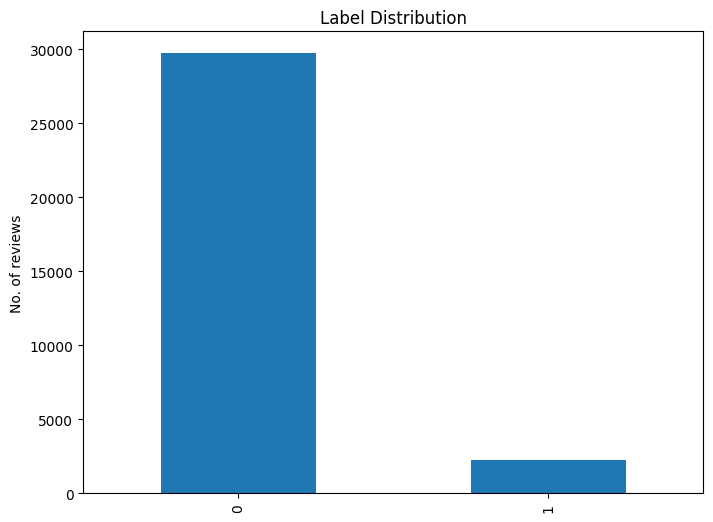

In [ ]:
data["label"].value_counts().plot(kind='bar',
                                     figsize=(8, 6),
                                     ylabel="No. of reviews",
                                    title="Label Distribution");

In [ ]:
from sklearn.utils import resample

# Assuming 'majority_class' is the label of the majority class
minority_class = data[data['label'] != 0]
majority_class = data[data['label'] == 0]

# Downsample the majority class to match the number of samples in the minority class
majority_class_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class))

# Combine the downsampled majority class with the minority class
balanced_df = pd.concat([minority_class, majority_class_downsampled])

In [ ]:
# Save the balanced data
balanced_df.to_csv('balanced_TwitterSentiment.csv', index=False)

In [ ]:
data = pd.read_csv('balanced_TwitterSentiment.csv')

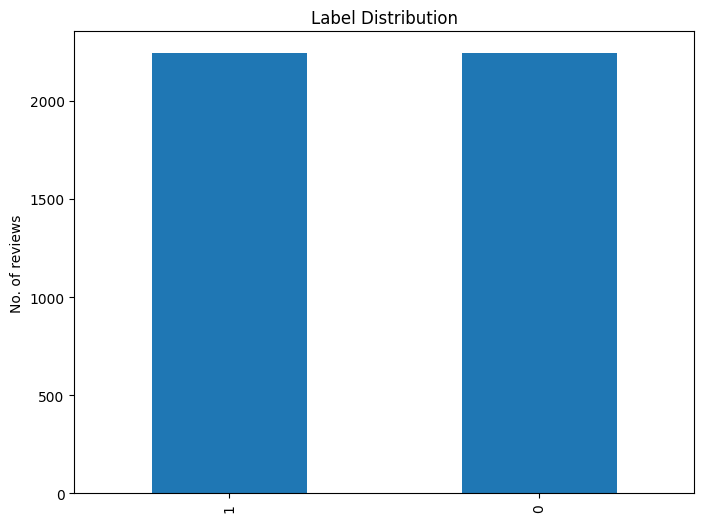

In [ ]:
data["label"].value_counts().plot(kind='bar',
                                     figsize=(8, 6),
                                     ylabel="No. of reviews",
                                    title="Label Distribution");

In [ ]:
avgLabel = data["label"].mean().round(2)
print(f"Average Label: {avgLabel}")

Average Label: 0.5


In [ ]:
label_counts = data['label'].value_counts()
print(label_counts)

1    2242
0    2242
Name: label, dtype: int64


Data Preprocessing

In [ ]:
# removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [ ]:
# remove twitter handles (@user)
data['clean_tweet'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*")
# remove special characters, numbers and punctuations
data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
# remove short words
data['clean_tweet'] = data['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
data.head()

<ipython-input-41-5549827c8b3b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")


,id,label,tweet,clean_tweet
0,14,1,@user #cnn calls #michigan middle school 'buil...,#cnn calls #michigan middle school build wall ...
1,15,1,no comment! in #australia #opkillingbay #se...,comment #australia #opkillingbay #seashepherd ...
2,18,1,retweet if you agree!,retweet agree
3,24,1,@user @user lumpy says i am a . prove it lumpy.,lumpy says prove lumpy
4,35,1,it's unbelievable that in the 21st century we'...,unbelievable that century need something like ...


Tokenization and Stemming

In [ ]:
# Download the 'punkt' resource from NLTK
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#firstReview = data["tweet"][0]
#print(firstReview)

In [ ]:
#firstReview_txtBlob = TextBlob(firstReview)
#print(firstReview_txtBlob.words)

In [ ]:
#print(firstReview_txtBlob.sentences)

In [ ]:
# Function for tokenization and stemming using TextBlob
def tokenize_and_stem(text):
    blob = TextBlob(text)
    stemmed_words = [word.stem() for word in blob.words]
    return stemmed_words

In [ ]:
# Apply tokenization and stemming to the existing 'clean_tweet' column
data['tokenize_stem_clean_tweet'] = data['clean_tweet'].apply(tokenize_and_stem)

In [ ]:
# Print the stemmed words
print(data['tokenize_stem_clean_tweet'].head())

0    [cnn, call, michigan, middl, school, build, wa...
1    [comment, australia, opkillingbay, seashepherd...
2                                      [retweet, agre]
3                           [lumpi, say, prove, lumpi]
4    [unbeliev, that, centuri, need, someth, like, ...
Name: tokenize_stem_clean_tweet, dtype: object


In [ ]:
# Join the stemmed words back into sentences
data['clean_tweet'] = data['tokenize_stem_clean_tweet'].apply(lambda words: " ".join(words))

# Drop the intermediate 'tokenize_stem_clean_tweet' column if desired
data = data.drop(columns=['tokenize_stem_clean_tweet'])

# Display the modified DataFrame
data.head()

,id,label,tweet,clean_tweet
0,14,1,@user #cnn calls #michigan middle school 'buil...,cnn call michigan middl school build wall chan...
1,15,1,no comment! in #australia #opkillingbay #se...,comment australia opkillingbay seashepherd hel...
2,18,1,retweet if you agree!,retweet agre
3,24,1,@user @user lumpy says i am a . prove it lumpy.,lumpi say prove lumpi
4,35,1,it's unbelievable that in the 21st century we'...,unbeliev that centuri need someth like thi aga...


Sentiment Analysis

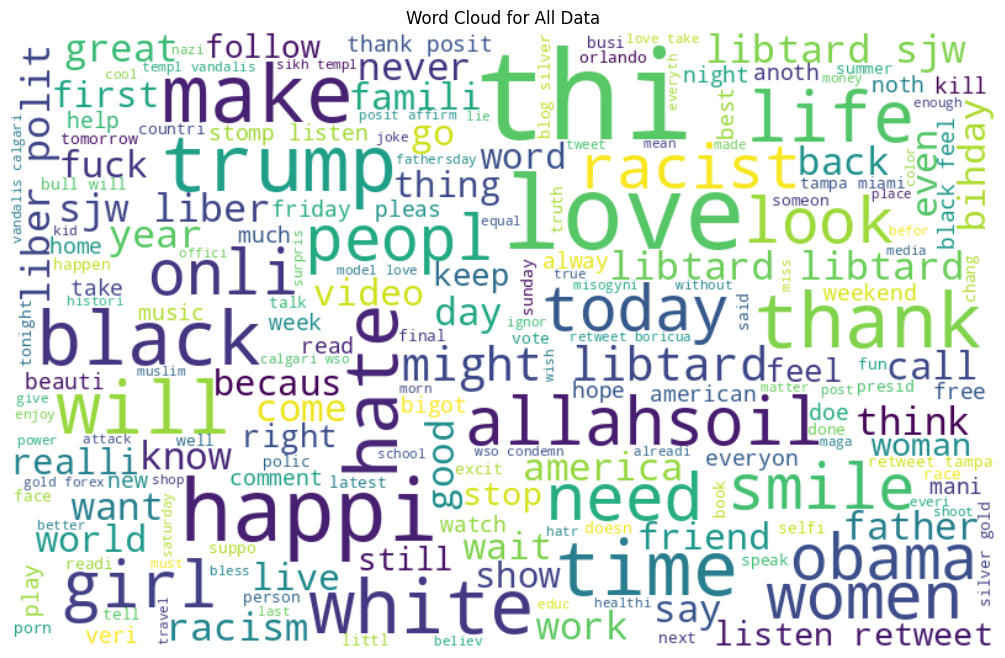

In [ ]:
# generate a word cloud for all the data without considering the labels
all_words = " ".join([sentence for sentence in data['clean_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100, background_color='white').generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Data')
plt.show()

In [ ]:
# Inspect sentiment labels and corresponding tweets for the first 5 tweets

# Additional insight for Understanding the sentiment expressed in the tweets (positive, negative, neutral)
# in addition to the racism classification label (column: label) by performing sentiment analysis using TextBlob

counter = 0
# Iterate over each tweet
for index, (tweet, label) in enumerate(zip(data['tweet'], data['label'])):
    # Perform sentiment analysis using TextBlob
    blob = TextBlob(tweet)
    sentiment = blob.sentiment.polarity

    # Classify the sentiment
    if sentiment <= 0:
        sentiment_label = 'Positive'
    elif sentiment > 0:
        sentiment_label = 'Negative'

    # Print sentiment, tweet, and the corresponding label
    print(f"Sentiment: {sentiment_label}, Label: {label}")
    print(f"Tweet: {tweet}")
    print('---')

    counter += 1

    # Break the loop after printing 5 rows
    if counter == 5:
        break


Sentiment: Positive, Label: 1
Tweet: @user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  
---
Sentiment: Positive, Label: 1
Tweet: no comment!  in #australia   #opkillingbay #seashepherd #helpcovedolphins #thecove  #helpcovedolphins
---
Sentiment: Positive, Label: 1
Tweet: retweet if you agree! 
---
Sentiment: Positive, Label: 1
Tweet: @user @user lumpy says i am a . prove it lumpy.
---
Sentiment: Positive, Label: 1
Tweet: it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia 
---


Positive Sentiment Review

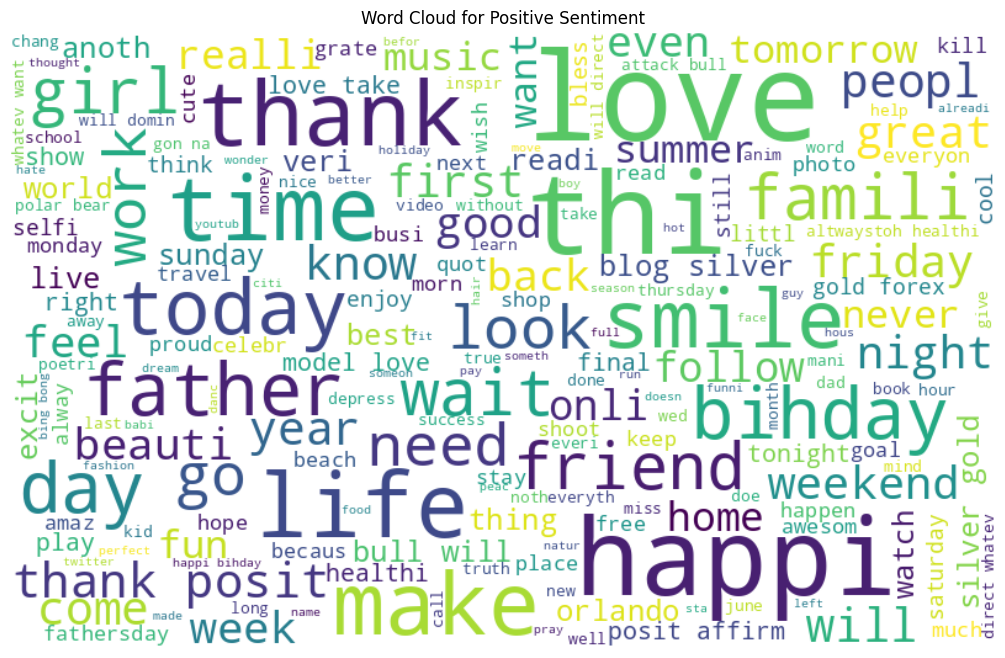

In [ ]:
# generates word clouds where the label = 0 (not racist/positive)
all_words = " ".join([sentence for sentence in data['clean_tweet'][data['label']==0]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100, background_color='white').generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

Text(0.5, 1.0, 'Bigram for Positive Review')

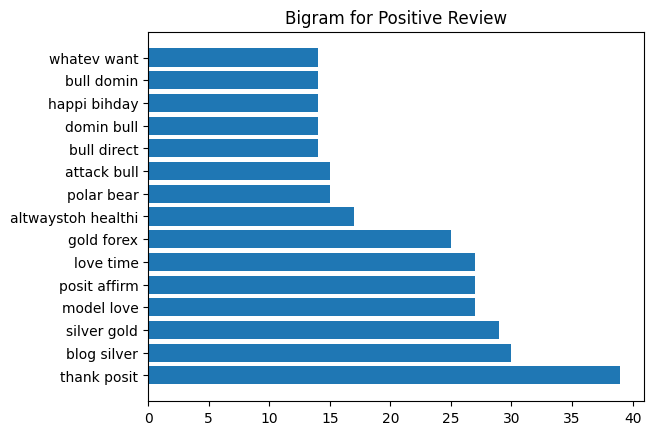

In [ ]:
# df of each category
df_positive = data[data["label"] <= 0]
df_negative =data[data["label"] > 0]

#nltk.download('stopwords')

# Bigram vectorizer
vect = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=1000)

# Positive tweets

bigram_positive = vect.fit_transform(df_positive['clean_tweet'])
bigram_positive_df = pd.DataFrame(
    bigram_positive.toarray(), columns=vect.get_feature_names_out())

bigram_frequency = pd.DataFrame(bigram_positive_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(
    by='frequency', ascending=False).head(15)

plt.barh(bigram_frequency["bigram"], width=bigram_frequency["frequency"]);
plt.title( "Bigram for Positive Review")

Negative Sentiment Reviews

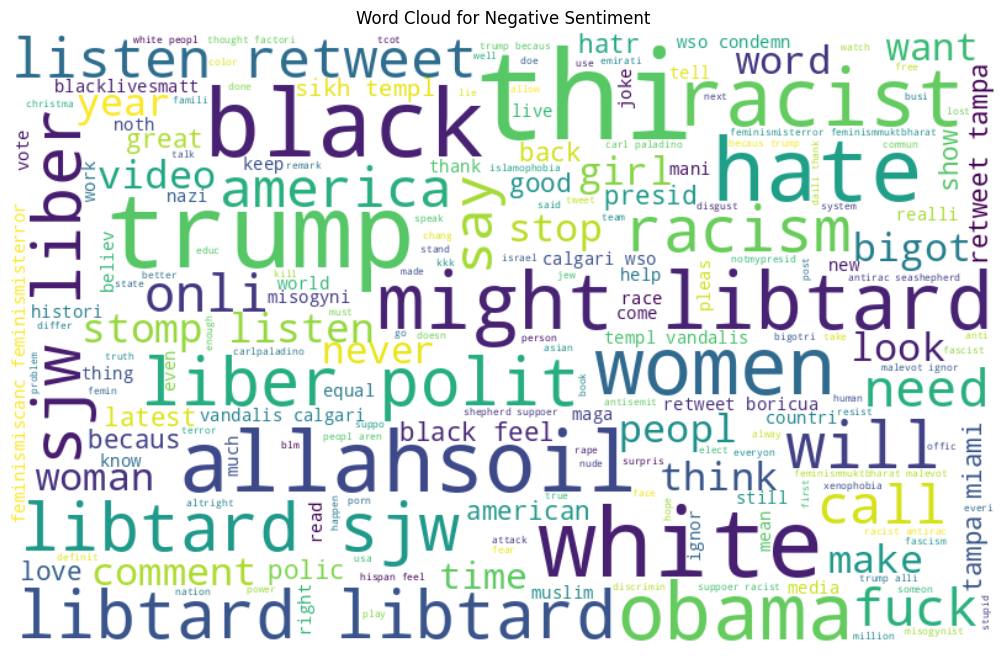

In [ ]:
# generates word clouds where the label = 1 (racist or sexist/negative)
all_words = " ".join([sentence for sentence in data['clean_tweet'][data['label']==1]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100, background_color='white').generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

Text(0.5, 1.0, 'Bigram for Negative Review')

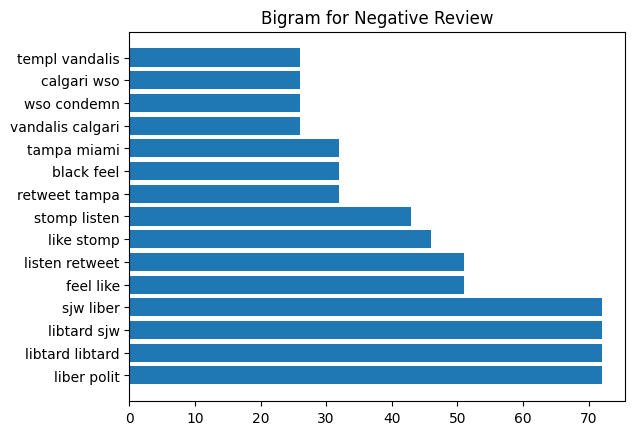

In [ ]:
# negative reviews
bigram_negative = vect.fit_transform(df_negative['clean_tweet'])
bigram_negative_df = pd.DataFrame(
    bigram_negative.toarray(), columns=vect.get_feature_names_out())

bigram_frequency = pd.DataFrame(bigram_negative_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(
    by='frequency', ascending=False).head(15)

plt.barh(bigram_frequency["bigram"], width=bigram_frequency["frequency"]);
plt.title( "Bigram for Negative Review")

Predictive Modelling

In [ ]:
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(data['tweet'], data['label'], test_size=0.3, random_state=42)

# Counter Vectorization
vectorizer = CountVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vect, y_train)

# Predictions
y_pred = nb_model.predict(X_test_vect)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8707280832095097
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       657
           1       0.87      0.88      0.87       689

    accuracy                           0.87      1346
   macro avg       0.87      0.87      0.87      1346
weighted avg       0.87      0.87      0.87      1346

Confusion Matrix:
 [[567  90]
 [ 84 605]]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Function for preprocessing user input
def preprocess_input(sentence):
    # Remove special characters, numbers, and extra whitespaces
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    # Convert to lowercase
    sentence = sentence.lower()
    # Stemming (optional)
    ps = PorterStemmer()
    sentence = ' '.join([ps.stem(word) for word in sentence.split()])
    return sentence

# Prompt the user to enter a sentence
user_input = input("Enter a sentence: ")

# Preprocess the user input
user_input = preprocess_input(user_input)

print(user_input)

# Vectorize the preprocessed input
input_vectorized = vectorizer.transform([user_input])

# Predict sentiment
predicted_sentiment = nb_model.predict(input_vectorized)

# Print the predicted sentiment
print("Predicted Sentiment:", predicted_sentiment[0])


Enter a sentence: As a woman you shouldn't complain about cleaning up your house.
as a woman you shouldnt complain about clean up your hous
Predicted Sentiment: 1
